<a href="https://colab.research.google.com/github/bhar-gav/MDS-COLAB/blob/main/FID_entity_pyramid_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
print(os.getcwd())
folder = "/content/drive/My Drive/Colab Notebooks/MDS"
os.chdir(folder)
print(os.getcwd())

Mounted at /content/drive
/content
/content/drive/My Drive/Colab Notebooks/MDS


In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("multi_news","n")


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['document', 'summary'],
        num_rows: 44972
    })
    validation: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
    test: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
})

In [ ]:
train=dataset["train"]
val=dataset["validation"]
test=dataset["test"]

print(train.info)


DatasetInfo(description='\nMulti-News, consists of news articles and human-written summaries\nof these articles from the site newser.com.\nEach summary is professionally written by editors and\nincludes links to the original articles cited.\n\nThere are two features:\n  - document: text of news articles seperated by special token "|||||".\n  - summary: news summary.\n', citation='\n@misc{alex2019multinews,\n    title={Multi-News: a Large-Scale Multi-Document Summarization Dataset and Abstractive Hierarchical Model},\n    author={Alexander R. Fabbri and Irene Li and Tianwei She and Suyi Li and Dragomir R. Radev},\n    year={2019},\n    eprint={1906.01749},\n    archivePrefix={arXiv},\n    primaryClass={cs.CL}\n}\n', homepage='https://github.com/Alex-Fabbri/Multi-News', license='For non-commercial research and educational purposes only', features={'document': Value(dtype='string', id=None), 'summary': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=SupervisedKeysDat

In [ ]:
print(train[:5])


{'document': ['National Archives \n \n Yes, it’s that time again, folks. It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street, Washington and Main Street are all aligned on one thing: Jobs. \n \n A fresh update on the U.S. employment situation for January hits the wires at 8:30 a.m. New York time offering one of the most important snapshots on how the economy fared during the previous month. Expectations are for 203,000 new jobs to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added in February. The unemployment rate is expected to hold steady at 8.3%. \n \n Here at MarketBeat HQ, we’ll be offering color commentary before and after the data crosses the wires. Feel free to weigh-in yourself, via the comments section. And while you’re here, why don’t you sign up to follow us on Twitter. \n \n Enjoy the show. ||||| Employers pulled back sharply on hiring last month, a reminder that the U.S. economy

**Preprocess**

In [ ]:
import pandas as pd


data = []

for entry in train:
    all_docs = entry["document"].split("|||||")
    for i, doc in enumerate(all_docs):
        doc = doc.replace("\n", " ")
        doc = " ".join(doc.split())
        all_docs[i] = doc

    tgt = entry["summary"]

    data.append({"documents": all_docs, "summary": tgt})

df = pd.DataFrame(data)
df.head()


,documents,summary
0,"[National Archives Yes, it’s that time again, ...",– The unemployment rate dropped to 8.2% last m...
1,[LOS ANGELES (AP) — In her first interview sin...,"– Shelly Sterling plans ""eventually"" to divorc..."
2,"[GAITHERSBURG, Md. (AP) — A small, private jet...",– A twin-engine Embraer jet that the FAA descr...
3,[Tucker Carlson Exposes His Own Sexism on Twit...,– Tucker Carlson is in deep doodoo with conser...
4,[A man accused of removing another man's testi...,– What are the three most horrifying words in ...


In [ ]:
print(len(df.loc[2, 'documents']))


2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44972 entries, 0 to 44971
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   documents  44972 non-null  object
 1   summary    44972 non-null  object
dtypes: object(2)
memory usage: 702.8+ KB


#**Entity etraction**

---



In [ ]:
!pip install spacy

**Entity Extraction**

In [ ]:
import spacy
import pandas as pd


nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    return [ent.text.lower() for ent in doc.ents]

def truncate_document(doc_text, max_length=1000000):
    if len(doc_text) > max_length:
        print(f"Document truncated from {len(doc_text)} to {max_length} characters.")
        return doc_text[:max_length-1]
    return doc_text

#
def extract_entities_from_documents(docs):
    all_entities = []
    for doc in docs:
        truncated_doc = truncate_document(doc)
        doc_entities = extract_entities(truncated_doc)
        all_entities.append(doc_entities)
    return all_entities



df['entities_docs'] = df['documents'].apply(lambda docs: extract_entities_from_documents(docs))

df.head()


Document truncated from 2894251 to 1000000 characters.


,documents,summary,entities_docs
0,"[National Archives Yes, it’s that time again, ...",– The unemployment rate dropped to 8.2% last m...,"[[national archives yes, the first friday of t..."
1,[LOS ANGELES (AP) — In her first interview sin...,"– Shelly Sterling plans ""eventually"" to divorc...","[[los angeles, ap, first, nba, shelly sterling..."
2,"[GAITHERSBURG, Md. (AP) — A small, private jet...",– A twin-engine Embraer jet that the FAA descr...,"[[gaithersburg, md., ap, maryland, montgomery ..."
3,[Tucker Carlson Exposes His Own Sexism on Twit...,– Tucker Carlson is in deep doodoo with conser...,"[[tucker carlson exposes, twitter, tucker carl..."
4,[A man accused of removing another man's testi...,– What are the three most horrifying words in ...,"[[port macquarie, allan george matthews, 57, p..."


In [ ]:
df.head()

,documents,summary,entities_docs
0,"[National Archives Yes, it’s that time again, ...",– The unemployment rate dropped to 8.2% last m...,"[[national archives yes, the first friday of t..."
1,[LOS ANGELES (AP) — In her first interview sin...,"– Shelly Sterling plans ""eventually"" to divorc...","[[los angeles, ap, first, nba, shelly sterling..."
2,"[GAITHERSBURG, Md. (AP) — A small, private jet...",– A twin-engine Embraer jet that the FAA descr...,"[[gaithersburg, md., ap, maryland, montgomery ..."
3,[Tucker Carlson Exposes His Own Sexism on Twit...,– Tucker Carlson is in deep doodoo with conser...,"[[tucker carlson exposes, twitter, tucker carl..."
4,[A man accused of removing another man's testi...,– What are the three most horrifying words in ...,"[[port macquarie, allan george matthews, 57, p..."


In [ ]:
df.to_csv("train_fid.csv", index=False)

#**2. Entity pyramid construction**
---

**> Salient sentence selection**

In [ ]:
import pandas as pd
df=pd.read_csv("train_fid.csv")
df.head()

#sentence selection

In [ ]:
!pip install pandas nltk rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=08516aa7e4163fdfef29a6efb02e4182bc51dd97dc362687e6f5422b29e73c0e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
import pandas as pd
df=pd.read_csv("train_fid.csv")
df.head()

,documents,summary,entities_docs
0,"['National Archives Yes, it’s that time again,...",– The unemployment rate dropped to 8.2% last m...,"[['national archives yes', 'the first friday o..."
1,['LOS ANGELES (AP) — In her first interview si...,"– Shelly Sterling plans ""eventually"" to divorc...","[['los angeles', 'ap', 'first', 'nba', 'shelly..."
2,"[""GAITHERSBURG, Md. (AP) — A small, private je...",– A twin-engine Embraer jet that the FAA descr...,"[['gaithersburg', 'md.', 'ap', 'maryland', 'mo..."
3,['Tucker Carlson Exposes His Own Sexism on Twi...,– Tucker Carlson is in deep doodoo with conser...,"[['tucker carlson exposes', 'twitter', 'tucker..."
4,"[""A man accused of removing another man's test...",– What are the three most horrifying words in ...,"[['port macquarie', 'allan george matthews', '..."


In [ ]:
def unwrap_single_element_list(doc_entry):
    if isinstance(doc_entry, list) and len(doc_entry) == 1 and isinstance(doc_entry[0], str):
        return doc_entry[0]
    return doc_entry

df['documents'] = df['documents'].apply(unwrap_single_element_list)

In [ ]:
df.head()

,documents,summary,entities_docs
0,"['National Archives Yes, it’s that time again,...",– The unemployment rate dropped to 8.2% last m...,"[['national archives yes', 'the first friday o..."
1,['LOS ANGELES (AP) — In her first interview si...,"– Shelly Sterling plans ""eventually"" to divorc...","[['los angeles', 'ap', 'first', 'nba', 'shelly..."
2,"[""GAITHERSBURG, Md. (AP) — A small, private je...",– A twin-engine Embraer jet that the FAA descr...,"[['gaithersburg', 'md.', 'ap', 'maryland', 'mo..."
3,['Tucker Carlson Exposes His Own Sexism on Twi...,– Tucker Carlson is in deep doodoo with conser...,"[['tucker carlson exposes', 'twitter', 'tucker..."
4,"[""A man accused of removing another man's test...",– What are the three most horrifying words in ...,"[['port macquarie', 'allan george matthews', '..."
...,...,...,...
44967,"[""More than 670,000 copies of the Pearls’ self...",– The deaths of three children have been linke...,"[['more than 670,000', 'christian', 'as early ..."
44968,['Seeking out cost-conscious consumers who hav...,"– Apple is hoping its new, cheaper iPhone can ...","[['android', 'apple', 'cupertino', 'calif.', '..."
44969,['Click to email this to a friend (Opens in ne...,"– January Jones, who plays the beleaguered wif...","[['opens', 'tumblr', 'twitter', 'opens', 'janu..."
44970,"['BARRINGTON, R.I. (AP) — Women clad in yoga p...",– A Rhode Island man who penned a letter to th...,"[['barrington', 'r.i.', 'ap', 'rhode island', ..."


In [ ]:
import pandas as pd
import spacy
import ast

# Load spaCy model
nlp = spacy.load("en_core_web_sm")
CHAR_LIMIT = 40_000

def safe_parse(doc_entry):
    if isinstance(doc_entry, list):
        return doc_entry
    if isinstance(doc_entry, str):
        try:
            parsed = ast.literal_eval(doc_entry)
            if isinstance(parsed, list):
                return parsed
            else:
                return [parsed]
        except:
            return [doc_entry]
    return [str(doc_entry)]

def segment_documents_spacy(doc_list):
    segmented = []
    for doc_text in doc_list:
        if not isinstance(doc_text, str):
            continue
        if len(doc_text) > CHAR_LIMIT:
            doc_text = doc_text[:CHAR_LIMIT]
        doc = nlp(doc_text)
        sentences = [sent.text.strip() for sent in doc.sents]
        segmented.append(sentences)
    return segmented

df_test = df.iloc[:5].copy()
df_test['documents'] = df_test['documents'].apply(safe_parse)
df_test['sentences_docs'] = df_test['documents'].apply(segment_documents_spacy)


df_test.head()


,documents,summary,entities_docs,sentences_docs
0,"[National Archives Yes, it’s that time again, ...",– The unemployment rate dropped to 8.2% last m...,"[['national archives yes', 'the first friday o...","[[National Archives, Yes, it’s that time again..."
1,[LOS ANGELES (AP) — In her first interview sin...,"– Shelly Sterling plans ""eventually"" to divorc...","[['los angeles', 'ap', 'first', 'nba', 'shelly...","[[LOS ANGELES (AP) —, In her first interview s..."
2,"[GAITHERSBURG, Md. (AP) — A small, private jet...",– A twin-engine Embraer jet that the FAA descr...,"[['gaithersburg', 'md.', 'ap', 'maryland', 'mo...","[[GAITHERSBURG, Md. (AP) — A small, private je..."
3,[Tucker Carlson Exposes His Own Sexism on Twit...,– Tucker Carlson is in deep doodoo with conser...,"[['tucker carlson exposes', 'twitter', 'tucker...",[[Tucker Carlson Exposes His Own Sexism on Twi...
4,[A man accused of removing another man's testi...,– What are the three most horrifying words in ...,"[['port macquarie', 'allan george matthews', '...",[[A man accused of removing another man's test...


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('summary').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('entities_docs').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['entities_docs'].value_counts()
    for x_label, grp in _df_2.groupby('summary')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('summary')
_ = plt.ylabel('entities_docs')

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
df['documents'] = df['documents'].apply(safe_parse)
df['sentences_docs'] = df['documents'].apply(segment_documents_spacy)

In [ ]:
df.head()

,documents,summary,entities_docs,sentences_docs
0,"[National Archives Yes, it’s that time again, ...",– The unemployment rate dropped to 8.2% last m...,"[['national archives yes', 'the first friday o...","[[National Archives, Yes, it’s that time again..."
1,[LOS ANGELES (AP) — In her first interview sin...,"– Shelly Sterling plans ""eventually"" to divorc...","[['los angeles', 'ap', 'first', 'nba', 'shelly...","[[LOS ANGELES (AP) —, In her first interview s..."
2,"[GAITHERSBURG, Md. (AP) — A small, private jet...",– A twin-engine Embraer jet that the FAA descr...,"[['gaithersburg', 'md.', 'ap', 'maryland', 'mo...","[[GAITHERSBURG, Md. (AP) — A small, private je..."
3,[Tucker Carlson Exposes His Own Sexism on Twit...,– Tucker Carlson is in deep doodoo with conser...,"[['tucker carlson exposes', 'twitter', 'tucker...",[[Tucker Carlson Exposes His Own Sexism on Twi...
4,[A man accused of removing another man's testi...,– What are the three most horrifying words in ...,"[['port macquarie', 'allan george matthews', '...",[[A man accused of removing another man's test...


In [ ]:
import pandas as pd
df=pd.read_csv("split_sent_train_fid.csv")



---



In [ ]:
df.head()

,documents,summary,entities_docs,sentences_docs
0,"['National Archives Yes, it’s that time again,...",– The unemployment rate dropped to 8.2% last m...,"[['national archives yes', 'the first friday o...","[['National Archives', 'Yes, it’s that time ag..."
1,['LOS ANGELES (AP) — In her first interview si...,"– Shelly Sterling plans ""eventually"" to divorc...","[['los angeles', 'ap', 'first', 'nba', 'shelly...","[['LOS ANGELES (AP) —', 'In her first intervie..."
2,"[""GAITHERSBURG, Md. (AP) — A small, private je...",– A twin-engine Embraer jet that the FAA descr...,"[['gaithersburg', 'md.', 'ap', 'maryland', 'mo...","[[""GAITHERSBURG, Md. (AP) — A small, private j..."
3,['Tucker Carlson Exposes His Own Sexism on Twi...,– Tucker Carlson is in deep doodoo with conser...,"[['tucker carlson exposes', 'twitter', 'tucker...",[['Tucker Carlson Exposes His Own Sexism on Tw...
4,"[""A man accused of removing another man's test...",– What are the three most horrifying words in ...,"[['port macquarie', 'allan george matthews', '...","[[""A man accused of removing another man's tes..."


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=63147fd2c485bf004edda1378a6bada472ba99c993f80c6bd01ea9a377c8f8df
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
df_copy=df.copy()

In [ ]:
df=df[:15000]
df

,documents,summary,entities_docs,sentences_docs
0,"['National Archives Yes, it’s that time again,...",– The unemployment rate dropped to 8.2% last m...,"[['national archives yes', 'the first friday o...","[['National Archives', 'Yes, it’s that time ag..."
1,['LOS ANGELES (AP) — In her first interview si...,"– Shelly Sterling plans ""eventually"" to divorc...","[['los angeles', 'ap', 'first', 'nba', 'shelly...","[['LOS ANGELES (AP) —', 'In her first intervie..."
2,"[""GAITHERSBURG, Md. (AP) — A small, private je...",– A twin-engine Embraer jet that the FAA descr...,"[['gaithersburg', 'md.', 'ap', 'maryland', 'mo...","[[""GAITHERSBURG, Md. (AP) — A small, private j..."
3,['Tucker Carlson Exposes His Own Sexism on Twi...,– Tucker Carlson is in deep doodoo with conser...,"[['tucker carlson exposes', 'twitter', 'tucker...",[['Tucker Carlson Exposes His Own Sexism on Tw...
4,"[""A man accused of removing another man's test...",– What are the three most horrifying words in ...,"[['port macquarie', 'allan george matthews', '...","[[""A man accused of removing another man's tes..."
...,...,...,...,...
14995,['Web wide crawl with initial seedlist and cra...,"– Well, that didn’t take long: Hilary Swank ha...","[['march 2011', 'kenji nagahashi', '23 decembe...",[['Web wide crawl with initial seedlist and cr...
14996,['IBM has been offering quantum computing as a...,"– ""We are really proud of this; it's a big fri...","[['ibm', 'quantum', 'last year', '5', 'today',...",[['IBM has been offering quantum computing as ...
14997,"[""Media playback is not supported on this devi...",– The slalom portion of the women's Alpine com...,"[['xxiii olympic winter games venue', 'pyeongc...",[['Media playback is not supported on this dev...
14998,['New love in her life? Tiffany Trump is repor...,"– Ah, it's heirs in love. Tiffany Trump is sai...","[['tiffany trump', 'michael boulos', 'ross mec...","[['New love in her life?', 'Tiffany Trump is r..."


In [ ]:
df=df_copy.copy()

for i in range(3):
    print(f"Before flattening - Row {i}:", df.loc[i, 'entities_docs'])


Before flattening - Row 0: [['national archives yes', 'the first friday of the month', 'one', 'washington', 'main street', 'one', 'u.s.', 'january', '8:30 a.m.', 'new york', 'the previous month', '203,000', 'dow jones newswires', '227,000', 'february', '8.3%', 'marketbeat hq', 'twitter']]
Before flattening - Row 1: [['los angeles', 'ap', 'first', 'nba', 'shelly sterling', 'the los angeles clippers', 'one day', 'donald sterling', 'los angeles clippers', 'shelly sterling', 'clippers', 'the oklahoma city thunder', "pierce o'donnell", 'the first half of game 3', 'associated press', 'shelly sterling', 'barbara walters', 'abc news', 'sunday', 'nba', 'adam silver', 'donald sterling', 'sterling', 'sterling', 'abc', 'shelly sterling', 'walters', 'sterling']]
Before flattening - Row 2: [['gaithersburg', 'md.', 'ap', 'maryland', 'montgomery county', 'monday', 'at least three', 'at least three', 'monday', 'gaithersburg', 'washington', 'd.c.', 'pete piringer', 'montgomery county fire', 'rescue', 'f

In [ ]:
print("Original Entities Docs:")
print(df['entities_docs'].head())


Original Entities Docs:
0    [['national archives yes', 'the first friday o...
1    [['los angeles', 'ap', 'first', 'nba', 'shelly...
2    [['gaithersburg', 'md.', 'ap', 'maryland', 'mo...
3    [['tucker carlson exposes', 'twitter', 'tucker...
4    [['port macquarie', 'allan george matthews', '...
Name: entities_docs, dtype: object


In [ ]:
import re

def extract_quoted_entities(entity_lists):
    try:

        all_chars = ''.join(str(char) for sublist in entity_lists for char in sublist)

        entities = re.findall(r'["\'](.*?)["\']', all_chars)

        return [e.strip() for e in entities if e.strip()]
    except Exception as e:
        print(f"Error processing {entity_lists}: {e}")
        return []

df['entities_docs'] = df['entities_docs'].apply(extract_quoted_entities)


df.head()


,documents,summary,entities_docs,sentences_docs
0,"['National Archives Yes, it’s that time again,...",– The unemployment rate dropped to 8.2% last m...,"[national archives yes, the first friday of th...","[['National Archives', 'Yes, it’s that time ag..."
1,['LOS ANGELES (AP) — In her first interview si...,"– Shelly Sterling plans ""eventually"" to divorc...","[los angeles, ap, first, nba, shelly sterling,...","[['LOS ANGELES (AP) —', 'In her first intervie..."
2,"[""GAITHERSBURG, Md. (AP) — A small, private je...",– A twin-engine Embraer jet that the FAA descr...,"[gaithersburg, md., ap, maryland, montgomery c...","[[""GAITHERSBURG, Md. (AP) — A small, private j..."
3,['Tucker Carlson Exposes His Own Sexism on Twi...,– Tucker Carlson is in deep doodoo with conser...,"[tucker carlson exposes, twitter, tucker carls...",[['Tucker Carlson Exposes His Own Sexism on Tw...
4,"[""A man accused of removing another man's test...",– What are the three most horrifying words in ...,"[port macquarie, allan george matthews, 57, po...","[[""A man accused of removing another man's tes..."


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   documents       15000 non-null  object
 1   summary         15000 non-null  object
 2   entities_docs   15000 non-null  object
 3   sentences_docs  15000 non-null  object
dtypes: object(4)
memory usage: 468.9+ KB


In [ ]:
from collections import defaultdict
import ast
from collections import Counter


df['documents'] = df['documents'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


entity_pyramids = []



for i, row in df.iterrows():
    documents = row['documents']
    entities = list(set(row['entities_docs']))
    entity_freq = {}

    for entity in entities:
        count = sum(1 for doc in documents if entity.lower() in doc.lower())
        if count > 0:
            entity_freq[entity] = count

    entity_pyramids.append(entity_freq)
    print(f"\nEntity Pyramid for row {i}:")
    for ent, freq in entity_freq.items():
        print(f"  Entity: {ent}, Frequency: {freq}")

df['entity_pyramid'] = entity_pyramids

print("Type of df['documents'][0]:", type(df['documents'][0]))

# Print the first item
print("\nSample data in df['documents'][0]:")
print(df['documents'][0])



Streaming output truncated to the last 5000 lines.
  Entity: 1:30 p.m., Frequency: 1
  Entity: sunday, Frequency: 2
  Entity: howard county, Frequency: 1
  Entity: handout / baltimore sun, Frequency: 1
  Entity: afternoon, Frequency: 2
  Entity: first, Frequency: 1
  Entity: associated press, Frequency: 1
  Entity: the virginia tech police department, Frequency: 1
  Entity: facebook / blacksburg police department), Frequency: 1
  Entity: wilde lake, Frequency: 2
  Entity: the baltimore sun, Frequency: 1
  Entity: wilde lake high school, Frequency: 2
  Entity: ap, Frequency: 2
  Entity: new river valley, Frequency: 1
  Entity: natalie keepers, Frequency: 1
  Entity: yakima, Frequency: 1
  Entity: the virginia tech corps of cadets, Frequency: 1
  Entity: surry county, Frequency: 1
  Entity: mike albert, Frequency: 1
  Entity: lovell, Frequency: 3
  Entity: madison lovell, Frequency: 3
  Entity: late saturday night, Frequency: 1
  Entity: north carolina, Frequency: 2
  Entity: 13-year-old

In [ ]:
import pandas as pd
import spacy
from collections import defaultdict
from rouge_score import rouge_scorer

# Load SpaCy and ROUGE scorer
nlp = spacy.load("en_core_web_sm")
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

selected_sentences = []
seen_sentences = set()
MAX_SENTENCES = 40

# Convert the entire column from string to actual list
df['sentences_docs'] = df['sentences_docs'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

sent_docs=df['sentences_docs']

print("Type of df['sentences_docs'][0]:", type(df['sentences_docs'][0]))

# Print the first item
print("\nSample data in df['documents'][0]:")
print(df['sentences_docs'][0])



Type of df['sentences_docs'][0]: <class 'list'>

Sample data in df['documents'][0]:
[['National Archives', 'Yes, it’s that time again, folks.', 'It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street, Washington and Main Street are all aligned on one thing: Jobs.', 'A fresh update on the U.S. employment situation for January hits the wires at 8:30 a.m.', 'New York time offering one of the most important snapshots on how the economy fared during the previous month.', 'Expectations are for 203,000 new jobs to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added in February.', 'The unemployment rate is expected to hold steady at 8.3%.', 'Here at MarketBeat HQ, we’ll be offering color commentary before and after the data crosses the wires.', 'Feel free to weigh-in yourself, via the comments section.', 'And while you’re here, why don’t you sign up to follow us on Twitter.', 'Enjoy the show.']]


In [ ]:
df.head()

,documents,summary,entities_docs,sentences_docs,entity_pyramid
0,"[National Archives Yes, it’s that time again, ...",– The unemployment rate dropped to 8.2% last m...,"[national archives yes, the first friday of th...","[[National Archives, Yes, it’s that time again...","{'national archives yes': 1, 'one': 1, 'dow jo..."
1,[LOS ANGELES (AP) — In her first interview sin...,"– Shelly Sterling plans ""eventually"" to divorc...","[los angeles, ap, first, nba, shelly sterling,...","[[LOS ANGELES (AP) —, In her first interview s...","{'shelly sterling': 1, 'los angeles clippers':..."
2,"[GAITHERSBURG, Md. (AP) — A small, private jet...",– A twin-engine Embraer jet that the FAA descr...,"[gaithersburg, md., ap, maryland, montgomery c...","[[GAITHERSBURG, Md. (AP) — A small, private je...","{'fourth': 1, 'maryland': 1, 'montgomery count..."
3,[Tucker Carlson Exposes His Own Sexism on Twit...,– Tucker Carlson is in deep doodoo with conser...,"[tucker carlson exposes, twitter, tucker carls...",[[Tucker Carlson Exposes His Own Sexism on Twi...,"{'conservatives': 1, 'tucker carlson': 1, 'eve..."
4,[A man accused of removing another man's testi...,– What are the three most horrifying words in ...,"[port macquarie, allan george matthews, 57, po...",[[A man accused of removing another man's test...,"{'june 23': 1, 'may 16': 1, 'port macquarie': ..."


In [ ]:
from rouge_score import rouge_scorer
from collections import defaultdict
import pandas as pd




scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def is_valid_sentence(sentence):
    return isinstance(sentence, str) and len(sentence.strip()) > 3 and sentence.strip()[0].isupper()

def select_representative_sentences(sentences_docs, entity_pyramid, max_sentences=40):
    selected_sentences = []
    seen_sentences = set()


    num_docs = len(sentences_docs)
    min_freq = 1 if num_docs == 1 else 2


    filtered_entities = {e: f for e, f in entity_pyramid.items() if f >= min_freq}
    sorted_entities = sorted(filtered_entities.items(), key=lambda x: x[1], reverse=True)

    for entity, _ in sorted_entities:
        for doc_idx, document in enumerate(sentences_docs):
            for sent in document:
                if not is_valid_sentence(sent):
                    continue
                normalized_sent = sent.lower().strip()
                if entity.lower() in normalized_sent and normalized_sent not in seen_sentences:
                    score_sum = 0
                    for other_idx, other_doc in enumerate(sentences_docs):
                        if other_idx != doc_idx:
                            for other_sent in other_doc:
                                if is_valid_sentence(other_sent):
                                    score = scorer.score(sent, other_sent)['rougeL'].fmeasure
                                    score_sum += score
                    selected_sentences.append((sent, score_sum))
                    seen_sentences.add(normalized_sent)
                    if len(selected_sentences) >= max_sentences:
                        break
            if len(selected_sentences) >= max_sentences:
                break
        if len(selected_sentences) >= max_sentences:
            break


    selected_sentences = sorted(selected_sentences, key=lambda x: x[1], reverse=True)
    return [s[0] for s in selected_sentences[:max_sentences]]


def process_all_clusters(df):
    representative_sentences_per_cluster = []

    for i, row in df.iterrows():
        print(f"Processing cluster {i}...")
        sentences_docs = row['sentences_docs']
        entity_pyramid = row['entity_pyramid']
        reps = select_representative_sentences(sentences_docs, entity_pyramid)
        representative_sentences_per_cluster.append(reps)

    df['representative_sentences'] = representative_sentences_per_cluster
    return df

df_updated = process_all_clusters(df)
df_updated.head()


Streaming output truncated to the last 5000 lines.
Processing cluster 10000...
Processing cluster 10001...
Processing cluster 10002...
Processing cluster 10003...
Processing cluster 10004...
Processing cluster 10005...
Processing cluster 10006...
Processing cluster 10007...
Processing cluster 10008...
Processing cluster 10009...
Processing cluster 10010...
Processing cluster 10011...
Processing cluster 10012...
Processing cluster 10013...
Processing cluster 10014...
Processing cluster 10015...
Processing cluster 10016...
Processing cluster 10017...
Processing cluster 10018...
Processing cluster 10019...
Processing cluster 10020...
Processing cluster 10021...
Processing cluster 10022...
Processing cluster 10023...
Processing cluster 10024...
Processing cluster 10025...
Processing cluster 10026...
Processing cluster 10027...
Processing cluster 10028...
Processing cluster 10029...
Processing cluster 10030...
Processing cluster 10031...
Processing cluster 10032...
Processing cluster 10033.

,documents,summary,entities_docs,sentences_docs,entity_pyramid,representative_sentences
0,"[National Archives Yes, it’s that time again, ...",– The unemployment rate dropped to 8.2% last m...,"[national archives yes, the first friday of th...","[[National Archives, Yes, it’s that time again...","{'national archives yes': 1, 'one': 1, 'dow jo...","[It’s the first Friday of the month, when for ..."
1,[LOS ANGELES (AP) — In her first interview sin...,"– Shelly Sterling plans ""eventually"" to divorc...","[los angeles, ap, first, nba, shelly sterling,...","[[LOS ANGELES (AP) —, In her first interview s...","{'shelly sterling': 1, 'los angeles clippers':...",[In her first interview since the NBA banned h...
2,"[GAITHERSBURG, Md. (AP) — A small, private jet...",– A twin-engine Embraer jet that the FAA descr...,"[gaithersburg, md., ap, maryland, montgomery c...","[[GAITHERSBURG, Md. (AP) — A small, private je...","{'fourth': 1, 'maryland': 1, 'montgomery count...",[He said a fourth person may have been aboard....
3,[Tucker Carlson Exposes His Own Sexism on Twit...,– Tucker Carlson is in deep doodoo with conser...,"[tucker carlson exposes, twitter, tucker carls...",[[Tucker Carlson Exposes His Own Sexism on Twi...,"{'conservatives': 1, 'tucker carlson': 1, 'eve...",[I am not down with @karlrove @tuckercarlson m...
4,[A man accused of removing another man's testi...,– What are the three most horrifying words in ...,"[port macquarie, allan george matthews, 57, po...",[[A man accused of removing another man's test...,"{'june 23': 1, 'may 16': 1, 'port macquarie': ...",[Matthews faced Port Macquarie Local Court on ...


In [ ]:
df.head()

,documents,summary,entities_docs,sentences_docs,entity_pyramid,representative_sentences
0,"[National Archives Yes, it’s that time again, ...",– The unemployment rate dropped to 8.2% last m...,"[national archives yes, the first friday of th...","[[National Archives, Yes, it’s that time again...","{'national archives yes': 1, 'one': 1, 'dow jo...","[It’s the first Friday of the month, when for ..."
1,[LOS ANGELES (AP) — In her first interview sin...,"– Shelly Sterling plans ""eventually"" to divorc...","[los angeles, ap, first, nba, shelly sterling,...","[[LOS ANGELES (AP) —, In her first interview s...","{'shelly sterling': 1, 'los angeles clippers':...",[In her first interview since the NBA banned h...
2,"[GAITHERSBURG, Md. (AP) — A small, private jet...",– A twin-engine Embraer jet that the FAA descr...,"[gaithersburg, md., ap, maryland, montgomery c...","[[GAITHERSBURG, Md. (AP) — A small, private je...","{'fourth': 1, 'maryland': 1, 'montgomery count...",[He said a fourth person may have been aboard....
3,[Tucker Carlson Exposes His Own Sexism on Twit...,– Tucker Carlson is in deep doodoo with conser...,"[tucker carlson exposes, twitter, tucker carls...",[[Tucker Carlson Exposes His Own Sexism on Twi...,"{'conservatives': 1, 'tucker carlson': 1, 'eve...",[I am not down with @karlrove @tuckercarlson m...
4,[A man accused of removing another man's testi...,– What are the three most horrifying words in ...,"[port macquarie, allan george matthews, 57, po...",[[A man accused of removing another man's test...,"{'june 23': 1, 'may 16': 1, 'port macquarie': ...",[Matthews faced Port Macquarie Local Court on ...


In [ ]:
df.to_csv("unsampled_final.csv")

In [ ]:
import random
from rouge_score import rouge_scorer

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# Set the number of new significant sentences to add
NUM_SAMPLES = 20
NUM_TOP_SENTENCES = 10

def enhance_representative_sentences(row):
    cluster_sentences = row['sentences_docs']
    current_representatives = set(sent.strip() for sent in row['representative_sentences'])

    # Flatten the cluster sentences into one list and filter out already used ones
    all_sentences = [sent for doc in cluster_sentences for sent in doc if sent.strip() not in current_representatives]

    if not all_sentences:
        return row['representative_sentences']

    # Sample random 20 sentences
    sampled_sentences = random.sample(all_sentences, min(NUM_SAMPLES, len(all_sentences)))

    # Score each sampled sentence by ROUGE-L against all current representative sentences
    scored = []
    for sent in sampled_sentences:
        score_sum = 0
        for rep in current_representatives:
            score = scorer.score(sent, rep)['rougeL'].fmeasure
            score_sum += score
        scored.append((sent, score_sum))

    # Sort by score descending and select top 10
    top_sentences = [sent for sent, _ in sorted(scored, key=lambda x: x[1], reverse=True)[:NUM_TOP_SENTENCES]]

    # Append to existing representatives
    return row['representative_sentences'] + top_sentences

# Apply enhancement to all rows
df['representative_sentences'] = df.apply(enhance_representative_sentences, axis=1)
df.head()


,documents,summary,entities_docs,sentences_docs,entity_pyramid,representative_sentences
0,"[National Archives Yes, it’s that time again, ...",– The unemployment rate dropped to 8.2% last m...,"[national archives yes, the first friday of th...","[[National Archives, Yes, it’s that time again...","{'national archives yes': 1, 'one': 1, 'dow jo...","[It’s the first Friday of the month, when for ..."
1,[LOS ANGELES (AP) — In her first interview sin...,"– Shelly Sterling plans ""eventually"" to divorc...","[los angeles, ap, first, nba, shelly sterling,...","[[LOS ANGELES (AP) —, In her first interview s...","{'shelly sterling': 1, 'los angeles clippers':...",[In her first interview since the NBA banned h...
2,"[GAITHERSBURG, Md. (AP) — A small, private jet...",– A twin-engine Embraer jet that the FAA descr...,"[gaithersburg, md., ap, maryland, montgomery c...","[[GAITHERSBURG, Md. (AP) — A small, private je...","{'fourth': 1, 'maryland': 1, 'montgomery count...",[He said a fourth person may have been aboard....
3,[Tucker Carlson Exposes His Own Sexism on Twit...,– Tucker Carlson is in deep doodoo with conser...,"[tucker carlson exposes, twitter, tucker carls...",[[Tucker Carlson Exposes His Own Sexism on Twi...,"{'conservatives': 1, 'tucker carlson': 1, 'eve...",[I am not down with @karlrove @tuckercarlson m...
4,[A man accused of removing another man's testi...,– What are the three most horrifying words in ...,"[port macquarie, allan george matthews, 57, po...",[[A man accused of removing another man's test...,"{'june 23': 1, 'may 16': 1, 'port macquarie': ...",[Matthews faced Port Macquarie Local Court on ...


In [ ]:
df.to_csv("sampled_final.csv")



---



----



---



---
#**Model**


In [ ]:
import pandas as pd
df=pd.read_csv("sampled_final.csv")

In [ ]:
df.head()

In [ ]:
import ast
# Convert the entire column from string to actual list
df['representative_sentences'] = df['representative_sentences'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
df.head()


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is 

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Assuming df is your original DataFrame
df = df.copy()

# Combine representative_sentences list into a single string per cluster
df['document'] = df['representative_sentences'].apply(lambda x: ' '.join(x))
df['id'] = [str(i) for i in range(len(df))]

# Keep only the required columns
df = df[['document', 'summary', 'id']]

# Perform 8:1:1 split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

# Create DatasetDict
dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

# Optional: check the dataset dictionary
print(dataset_dict)


DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 12000
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 1500
    })
})


In [ ]:
xsum=dataset_dict


xsum
```
DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 12000
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 1500
    })
})
```



In [ ]:
!pip install transformers torch rouge-score


In [ ]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-small')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
def preprocess_function(examples):
    inputs = [doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(examples["summary"], max_length=128, truncation=True, padding=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
xsum = xsum.map(preprocess_function, batched=True)
xsum

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 12000
    })
    validation: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
})

In [ ]:
xsum=xsum.remove_columns(['document', 'summary','id'])
xsum

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
})

In [ ]:
# save_path = '/content/drive/MyDrive/dataset_dict'

# xsum.save_to_disk(save_path)

# print(f"DatasetDict saved to {save_path}")

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1500 [00:00<?, ? examples/s]

DatasetDict saved to /content/drive/MyDrive/dataset_dict


In [ ]:
!pip install datasets
from datasets import DatasetDict

load_path = '/content/drive/MyDrive/dataset_dict'
xsum = DatasetDict.load_from_disk(load_path)




In [ ]:
print(xsum)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
})


In [ ]:
from transformers import T5ForConditionalGeneration, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="t5-small")

model=T5ForConditionalGeneration.from_pretrained('t5-small')


In [ ]:
!pip install evaluate
import evaluate

rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Optional: Strip whitespace to improve ROUGE scoring
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    return result  # or return only specific keys like {'rougeL': result['rougeL']}


In [ ]:

# training arguments
training_arguments = Seq2SeqTrainingArguments(
            output_dir='./results',
            # evaluation_strategy='epoch',

            #save_strategy='epoch',  #save model state after each epoch (space consuming)
            save_strategy='no',  #1. use to save model only once after finishing training (comment out above line in case)

            logging_dir='./logs',
            learning_rate=2e-5,
            per_device_train_batch_size=4,
            per_device_eval_batch_size=1,
            weight_decay=0.01,
            save_total_limit=4,
            num_train_epochs=10,
            # remove_unused_columns=False,
            fp16=True,
            )





trainer = Seq2SeqTrainer(
    model=model,
    args=training_arguments,
    train_dataset=xsum['train'],
    eval_dataset=xsum['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



<ipython-input-11-26e341ed996f>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()
trainer.save_model()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bhar_gav (bhar_gav-national-institute-of-technology-hamirpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
500,3.634200
1000,3.328100
1500,3.300500
2000,3.268500
2500,3.225300
3000,3.198200
3500,3.179000
4000,3.147400
4500,3.153300
5000,3.180700


In [ ]:
from transformers import DataCollatorForSeq2Seq
from torch.utils.data import DataLoader
import torch

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

def generate_summaries(test_dataset, model, tokenizer, batch_size=4, max_output_length=128):
    model.eval()
    all_summaries = []

    dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=data_collator)

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)

        summary_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_output_length,
            num_beams=2,
            length_penalty=2.0,
            early_stopping=True
        )


        summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
        all_summaries.extend(summaries)

    return all_summaries

# generated_summaries = generate_summaries(xsum['test'], model, tokenizer)

# for i in range(5):
#     print(f"Generated Summary {i+1}: {generated_summaries[i]}")


In [ ]:
!pip install evaluate


In [ ]:
import evaluate

rouge = evaluate.load("rouge")

def decode_labels(labels, tokenizer):
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return decoded_labels

generated_summaries = generate_summaries(xsum['test'], model, tokenizer)
reference_summaries = decode_labels(xsum['test']['labels'], tokenizer)


def calculate_rouge(generated_summaries, reference_summaries):
    results = rouge.compute(predictions=generated_summaries, references=reference_summaries, rouge_types=["rouge1", "rouge2", "rougeL", "rouge4"])
    return results

rouge_results = calculate_rouge(generated_summaries, reference_summaries)


print("ROUGE Scores:")
print(rouge_results)



ROUGE Scores:
{'rouge1': np.float64(0.33456322476608114), 'rouge2': np.float64(0.09445958092220777), 'rougeL': np.float64(0.19377124713548383), 'rouge4': np.float64(0.026440315270086737)}


In [ ]:
rouge_results

{'rouge1': np.float64(0.33456322476608114),
 'rouge2': np.float64(0.09445958092220777),
 'rougeL': np.float64(0.19377124713548383),
 'rouge4': np.float64(0.026440315270086737)}

In [ ]:
import pandas as pd
df = pd.DataFrame({
    "generated_summary": generated_summaries,
    "reference_summary": reference_summaries
})

df.to_csv("test_results_128.csv", index=False)

In [ ]:
import pandas as pd
df=pd.read_csv("test_results_128.csv")

In [ ]:
df.head()

,generated_summary,reference_summary
0,– An apparently fake People magazine cover on ...,– A phony People magazine on which Taylor Laut...
1,– Republicans are distancing themselves from K...,– The man expected to be next the House speake...
2,– Ivory Coast has banned skin-whitening creams...,"– Ivory Coast's health ministry has ""forbidden..."
3,"– Rudy Bruynius, 33, and daughter McKayla, 2, ...",– A family in England is in mourning after a v...
4,"– Skydiver Luke Aikins has made 18,000 parachu...",– An hour-long live TV special on Fox Saturday...


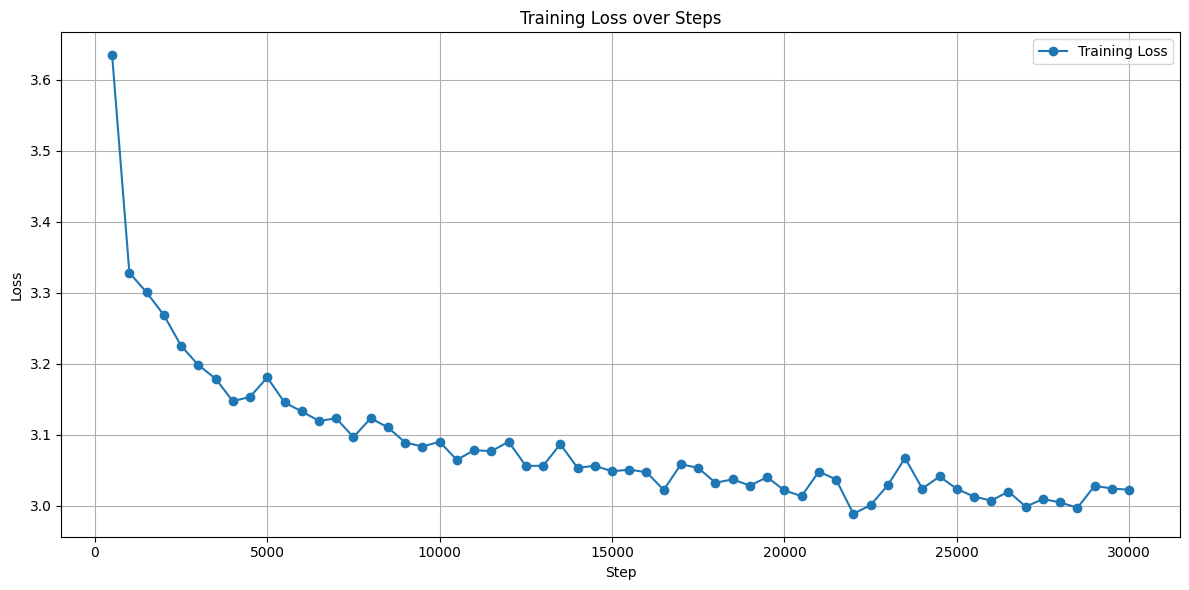

In [ ]:
import matplotlib.pyplot as plt

steps = list(range(500, 30001, 500))
training_loss = [
    3.6342, 3.3281, 3.3005, 3.2685, 3.2253, 3.1982, 3.1790, 3.1474, 3.1533, 3.1807,
    3.1456, 3.1328, 3.1196, 3.1231, 3.0967, 3.1233, 3.1104, 3.0891, 3.0835, 3.0902,
    3.0646, 3.0784, 3.0769, 3.0902, 3.0563, 3.0563, 3.0868, 3.0534, 3.0565, 3.0486,
    3.0509, 3.0474, 3.0224, 3.0585, 3.0534, 3.0325, 3.0373, 3.0285, 3.0403, 3.0217,
    3.0137, 3.0483, 3.0370, 2.9888, 3.0010, 3.0291, 3.0673, 3.0242, 3.0413, 3.0238,
    3.0130, 3.0074, 3.0201, 2.9988, 3.0096, 3.0048, 2.9973, 3.0282, 3.0244, 3.0226
]

plt.figure(figsize=(12, 6))
plt.plot(steps, training_loss, label='Training Loss', marker='o')
plt.title('Training Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save plot to file
plt.savefig("training_loss_plot.png", dpi=300)
plt.show()
